# Inbalanced learn examples

 Using the module inbalanced learn to balanced our dataset (increase positives)
 To install "pip install -U imbalanced-learn" or "conda install -c glemaitre imbalanced-learn"

In [1]:
import imblearn
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interp
from itertools import cycle
from sklearn import svm, datasets, preprocessing
from sklearn.svm import SVC  
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, matthews_corrcoef, roc_curve, auc, make_scorer
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
import bisect
from immas import classification
from sklearn.utils import shuffle

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter

In [16]:
# Loading of data and splitting in groups according to images
# Regions of the same image will stay in the same Pandas Dataframe in the end (dataset_df1 or dataset_df2)

# Load the dataset and groups by image filename
filename = "C:\\AIA-2018\\examples\\feature-tables\\train-data_1527086478.csv"
dataset_df1, dataset_df2 = classification.load_features_data(filename)

# Conversion from pandas dataframe to numpy array
# Keeps all the features from the original csv file
Feature = dataset_df1.drop(['class_id','img_name'], axis=1)
Target  = dataset_df1['class_id']
dataset01_data = Feature.as_matrix()
dataset01_labels = Target.as_matrix()

Feature = dataset_df2.drop(['class_id','img_name'], axis=1)
Target  = dataset_df2['class_id']
dataset02_data = Feature.as_matrix()
dataset02_labels = Target.as_matrix()

# Shuflles the datasets and creates one variable with labels for all the samples
dataset01_data, dataset01_labels = shuffle(dataset01_data, dataset01_labels, random_state=None)
dataset02_data, dataset02_labels = shuffle(dataset02_data, dataset02_labels, random_state=None)
all_data = np.vstack((dataset01_data, dataset02_data))
all_labels = np.concatenate((dataset01_labels, dataset02_labels),axis=0)

# Data standardization for each dataset (two methods)
dataset01_data = preprocessing.StandardScaler().fit_transform(dataset01_data)
dataset02_data = preprocessing.StandardScaler().fit_transform(dataset02_data)
all_data = preprocessing.StandardScaler().fit_transform(all_data)
#dataset01_data = preprocessing.robust_scale(dataset01_data)fit_transform
#dataset02_data = preprocessing.robust_scale(dataset02_data)

# Concatenates data and labels of dataset01 into one array
dataset01 = np.zeros((dataset01_data.shape[0],dataset01_data.shape[1]+1));
dataset01[:,:-1] = dataset01_data
dataset01[:,-1] = dataset01_labels

# Concatenates data and labels of dataset02 into one array
dataset02 = np.zeros((dataset02_data.shape[0],dataset02_data.shape[1]+1));
dataset02[:,:-1] = dataset02_data
dataset02[:,-1] = dataset02_labels

Number of images in the dataset 01: 205
Number of images in the dataset 02: 205
Number of regions in dataset 01: 3223
Number of regions in dataset 02: 3153


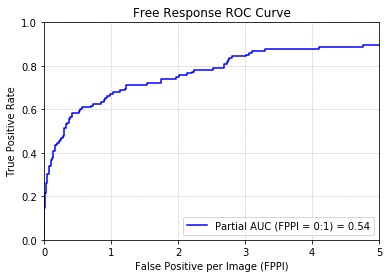

Area under the original ROC curve for our classifier: 0.92
Partial area under the FROC curve for FPPI between 0 and 1: 0.53735


In [17]:
# Running with parameters otpimized for features without LBP (oversampling)
oversampling_kernel = SMOTE(random_state=0,k_neighbors=10, m_neighbors=5,kind = 'svm')
_,_,_,_,_ = classification.optimal_oversampling_SVM (dataset01, dataset02, oversampling_kernel, kernel='rbf', features='all_except_LBP')

In [8]:
# Data Augmentation with over sampling

# Parameters for features without LBP
oversampling_kernel = SMOTE(random_state=0,k_neighbors=10, m_neighbors=5,kind = 'svm')

# Parameters for features with LBP
#oversampling_kernel = SMOTE(random_state=0,k_neighbors=5, m_neighbors=20,kind = 'borderline2')

dataset01_data_resampled, dataset01_labels_resampled = oversampling_kernel.fit_sample(dataset01_data, dataset01_labels)
dataset02_data_resampled, dataset02_labels_resampled = oversampling_kernel.fit_sample(dataset02_data, dataset02_labels)
all_data = np.vstack((dataset01_data_resampled, dataset02_data_resampled))
all_labels = np.concatenate((dataset01_labels_resampled, dataset02_labels_resampled),axis=0)

In [9]:
# Extensive Grid Searches

# Grid Search parameters
parameters1 = {'C': [0.001, 0.01, 0.1, 0.5, 5, 7, 10, 20, 50, 200], 'gamma': [1e-4, 1e-3, 0.0003, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.5], 'kernel': ['rbf'],
              'class_weight':['balanced', None, {1:1},{1:3},{1:5},{1:7},{1:9},{1:10},{1:15},{1:20},{1:25},{1:30},{1:50},{1:100}]}

parameters2 = {'C': [0.001, 0.01, 0.1, 0.5, 5, 7, 9, 10, 50, 200], 'gamma': [1e-4, 1e-3, 0.0005, 0.001, 0.005, 0.01, 0.03, 0.05, 0.1, 0.5], 'kernel': ['sigmoid'],
               'class_weight':['balanced', None, {1:1},{1:3},{1:5},{1:7},{1:9},{1:10},{1:15},{1:17},{1:20},{1:50},{1:100}]}

parameters3 = {'C': [0.0001, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.1, 0.5, 5, 7, 8, 9, 10, 15, 20],'kernel': ['linear'],
               'class_weight':['balanced', None, {1:1},{1:3},{1:5},{1:7},{1:9},{1:10},{1:15},{1:20},{1:22},{1:24},{1:30},{1:40},{1:50},{1:100}]}

parameters4 = {'C': [0.01, 0.1, 0.3, 0.5, 1, 7, 10, 100], 'gamma': [1e-3, 0.01, 0.05, 0.1], 'kernel': ['poly'],
               'class_weight':['balanced',{1:5},{1:10},{1:50}],'degree':[1,3,5], 'coef0':[0.0, 0.5, 1.0, 1.5]}

gridSVM = svm.SVC()

In [11]:
grid_search1 = GridSearchCV(gridSVM, param_grid=parameters1, scoring='roc_auc', refit=True, n_jobs=2, pre_dispatch='2*n_jobs', cv=2, verbose=2, return_train_score=False)
grid_search1.fit(all_data, all_labels)
print(grid_search1.best_score_, grid_search1.best_params_)

Fitting 2 folds for each of 1260 candidates, totalling 2520 fits


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  3.7min
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:  7.8min
[Parallel(n_jobs=2)]: Done 644 tasks      | elapsed: 11.8min
[Parallel(n_jobs=2)]: Done 1009 tasks      | elapsed: 15.8min
[Parallel(n_jobs=2)]: Done 1454 tasks      | elapsed: 18.6min
[Parallel(n_jobs=2)]: Done 1981 tasks      | elapsed: 21.5min
[Parallel(n_jobs=2)]: Done 2520 out of 2520 | elapsed: 24.9min finished


0.9815569090357286 {'C': 5, 'class_weight': 'balanced', 'gamma': 0.0003, 'kernel': 'rbf'}


In [12]:
grid_search2 = GridSearchCV(gridSVM, param_grid=parameters2, scoring='roc_auc', refit=True, n_jobs=2, pre_dispatch='2*n_jobs', cv=2, verbose=2, return_train_score=False)
grid_search2.fit(all_data, all_labels)
print(grid_search2.best_score_, grid_search2.best_params_)

Fitting 2 folds for each of 1300 candidates, totalling 2600 fits


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  4.4min
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:  8.8min
[Parallel(n_jobs=2)]: Done 644 tasks      | elapsed: 13.6min
[Parallel(n_jobs=2)]: Done 1009 tasks      | elapsed: 18.1min
[Parallel(n_jobs=2)]: Done 1454 tasks      | elapsed: 21.8min
[Parallel(n_jobs=2)]: Done 1981 tasks      | elapsed: 26.0min
[Parallel(n_jobs=2)]: Done 2588 tasks      | elapsed: 30.3min
[Parallel(n_jobs=2)]: Done 2600 out of 2600 | elapsed: 30.4min finished


0.9816221413607529 {'C': 0.5, 'class_weight': 'balanced', 'gamma': 0.005, 'kernel': 'sigmoid'}


In [13]:
grid_search3 = GridSearchCV(gridSVM, param_grid=parameters3, scoring='roc_auc', refit=True, n_jobs=2, pre_dispatch='2*n_jobs', cv=2, verbose=2, return_train_score=False)
grid_search3.fit(all_data, all_labels)
print(grid_search3.best_score_, grid_search3.best_params_)

Fitting 2 folds for each of 240 candidates, totalling 480 fits


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   26.1s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:  3.0min
[Parallel(n_jobs=2)]: Done 480 out of 480 | elapsed:  6.1min finished


0.9807574964927842 {'C': 0.001, 'class_weight': None, 'kernel': 'linear'}


In [10]:
grid_search4 = GridSearchCV(gridSVM, param_grid=parameters4, scoring='roc_auc', refit=True, n_jobs=2, pre_dispatch='2*n_jobs', cv=2, verbose=2, return_train_score=False)
grid_search4.fit(all_data, all_labels)
print(grid_search4.best_score_, grid_search4.best_params_)

Fitting 2 folds for each of 1536 candidates, totalling 3072 fits


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   29.1s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:  3.2min
[Parallel(n_jobs=2)]: Done 644 tasks      | elapsed:  5.1min
[Parallel(n_jobs=2)]: Done 1009 tasks      | elapsed:  7.4min
[Parallel(n_jobs=2)]: Done 1454 tasks      | elapsed:  9.8min
[Parallel(n_jobs=2)]: Done 1981 tasks      | elapsed: 12.7min
[Parallel(n_jobs=2)]: Done 2588 tasks      | elapsed: 16.4min
[Parallel(n_jobs=2)]: Done 3072 out of 3072 | elapsed: 21.1min finished


0.9815116698810286 {'C': 0.3, 'class_weight': 'balanced', 'coef0': 1.0, 'degree': 5, 'gamma': 0.001, 'kernel': 'poly'}


In [14]:
print(grid_search1.best_score_, grid_search1.best_params_)
print(grid_search2.best_score_, grid_search2.best_params_)
print(grid_search3.best_score_, grid_search3.best_params_)
print(grid_search4.best_score_, grid_search4.best_params_)

0.9815569090357286 {'C': 5, 'class_weight': 'balanced', 'gamma': 0.0003, 'kernel': 'rbf'}
0.9816221413607529 {'C': 0.5, 'class_weight': 'balanced', 'gamma': 0.005, 'kernel': 'sigmoid'}
0.9807574964927842 {'C': 0.001, 'class_weight': None, 'kernel': 'linear'}
0.9815116698810286 {'C': 0.3, 'class_weight': 'balanced', 'coef0': 1.0, 'degree': 5, 'gamma': 0.001, 'kernel': 'poly'}


In [2]:
# LBP EXPERIMENTS

# Loading of data and splitting in groups according to images
# Regions of the same image will stay in the same Pandas Dataframe in the end (dataset_df1 or dataset_df2)

# Load the dataset and groups by image filename
filename = "C:\\AIA-2018\\examples\\feature-tables\\train-data_1527093743.csv"
dataset_df1, dataset_df2 = classification.load_features_data(filename)

# Conversion from pandas dataframe to numpy array
# Keeps all the features from the original csv file
Feature = dataset_df1.drop(['class_id','img_name'], axis=1)
Target  = dataset_df1['class_id']
dataset01_data = Feature.as_matrix()
dataset01_labels = Target.as_matrix()

Feature = dataset_df2.drop(['class_id','img_name'], axis=1)
Target  = dataset_df2['class_id']
dataset02_data = Feature.as_matrix()
dataset02_labels = Target.as_matrix()

# Shuflles the datasets and creates one variable with labels for all the samples
dataset01_data, dataset01_labels = shuffle(dataset01_data, dataset01_labels, random_state=None)
dataset02_data, dataset02_labels = shuffle(dataset02_data, dataset02_labels, random_state=None)
all_data = np.vstack((dataset01_data, dataset02_data))
all_labels = np.concatenate((dataset01_labels, dataset02_labels),axis=0)

# Data standardization for each dataset (two methods)
dataset01_data = preprocessing.StandardScaler().fit_transform(dataset01_data)
dataset02_data = preprocessing.StandardScaler().fit_transform(dataset02_data)
all_data = preprocessing.StandardScaler().fit_transform(all_data)
#dataset01_data = preprocessing.robust_scale(dataset01_data)fit_transform
#dataset02_data = preprocessing.robust_scale(dataset02_data)

# Concatenates data and labels of dataset01 into one array
dataset01 = np.zeros((dataset01_data.shape[0],dataset01_data.shape[1]+1));
dataset01[:,:-1] = dataset01_data
dataset01[:,-1] = dataset01_labels

# Concatenates data and labels of dataset02 into one array
dataset02 = np.zeros((dataset02_data.shape[0],dataset02_data.shape[1]+1));
dataset02[:,:-1] = dataset02_data
dataset02[:,-1] = dataset02_labels

# LBP oversampling
oversampling_kernel = SMOTE(random_state=0,k_neighbors=5, m_neighbors=20,kind = 'borderline2')

dataset01_data_resampled, dataset01_labels_resampled = oversampling_kernel.fit_sample(dataset01_data, dataset01_labels)
dataset02_data_resampled, dataset02_labels_resampled = oversampling_kernel.fit_sample(dataset02_data, dataset02_labels)
all_data = np.vstack((dataset01_data_resampled, dataset02_data_resampled))
all_labels = np.concatenate((dataset01_labels_resampled, dataset02_labels_resampled),axis=0)

Number of images in the dataset 01: 205
Number of images in the dataset 02: 205
Number of regions in dataset 01: 3119
Number of regions in dataset 02: 3257


In [5]:
# Extensive Grid Searches for LBP (less parameters)

# Grid Search parameters
parameters1 = {'C': [0.001, 0.01, 0.1, 0.5, 10, 100], 'gamma': [1e-4, 1e-3, 0.001, 0.1], 'kernel': ['rbf'],
              'class_weight':[{1:7},{1:50}]}

parameters2 = {'C': [0.001, 0.01, 0.1, 0.5, 10, 100], 'gamma': [1e-4, 1e-3, 0.001, 0.1], 'kernel': ['sigmoid'],
               'class_weight':[{1:5},{1:10},{1:50}]}

parameters3 = {'C': [0.001, 0.01, 0.1, 0.5, 10, 100],'kernel': ['linear'],
               'class_weight':[None, {1:1},{1:5},{1:7},{1:10},{1:20},{1:30},{1:100}]}

parameters4 = {'C': [0.001, 0.01, 0.1, 0.5], 'gamma': [1e-3, 0.01, 0.1], 'kernel': ['poly'],
               'class_weight':[{1:5},{1:10},{1:50}],'degree':[1,3], 'coef0':[0.0, 0.5, 1.0]}

gridSVM = svm.SVC()

In [8]:
grid_search1_lbp = GridSearchCV(gridSVM, param_grid=parameters1, scoring='roc_auc', refit=True, n_jobs=2, pre_dispatch='2*n_jobs', cv=2, verbose=2, return_train_score=False)
grid_search1_lbp.fit(all_data, all_labels)
print(grid_search1_lbp.best_score_, grid_search1_lbp.best_params_)

Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed: 19.1min
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed: 38.7min finished


0.9897472790360184 {'C': 0.5, 'class_weight': {1: 7}, 'gamma': 0.001, 'kernel': 'rbf'}


In [9]:
grid_search2_lbp = GridSearchCV(gridSVM, param_grid=parameters2, scoring='roc_auc', refit=True, n_jobs=2, pre_dispatch='2*n_jobs', cv=2, verbose=3, return_train_score=False)
grid_search2_lbp.fit(all_data, all_labels)
print(grid_search2_lbp.best_score_, grid_search2_lbp.best_params_)

Fitting 2 folds for each of 72 candidates, totalling 144 fits


[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed: 14.3min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 42.3min
[Parallel(n_jobs=2)]: Done 144 out of 144 | elapsed: 45.6min finished


0.9072747459413429 {'C': 0.5, 'class_weight': {1: 50}, 'gamma': 0.0001, 'kernel': 'sigmoid'}


In [ ]:
grid_search3_lbp = GridSearchCV(gridSVM, param_grid=parameters3, scoring='roc_auc', refit=True, n_jobs=2, pre_dispatch='2*n_jobs', cv=2, verbose=3, return_train_score=False)
grid_search3_lbp.fit(all_data, all_labels)
print(grid_search3_lbp.best_score_, grid_search3_lbp.best_params_)

Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  2.9min
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:  8.2min finished


0.8929730686477972 {'C': 0.001, 'class_weight': {1: 7}, 'kernel': 'linear'}


In [6]:
grid_search4_lbp = GridSearchCV(gridSVM, param_grid=parameters4, scoring='roc_auc', refit=True, n_jobs=2, pre_dispatch='2*n_jobs', cv=2, verbose=3, return_train_score=False)
grid_search4_lbp.fit(all_data, all_labels)
print(grid_search4_lbp.best_score_, grid_search4_lbp.best_params_)

Fitting 2 folds for each of 216 candidates, totalling 432 fits


[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed: 14.4min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 56.6min
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed: 108.9min
[Parallel(n_jobs=2)]: Done 432 out of 432 | elapsed: 148.3min finished


0.9623059132844874 {'C': 0.001, 'class_weight': {1: 5}, 'coef0': 1.0, 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'}


In [ ]:
# Results for extensive Grid Searches
print(grid_search1_lbp.best_score_, grid_search1_lbp.best_params_)
print(grid_search2_lbp.best_score_, grid_search2_lbp.best_params_)
print(grid_search3_lbp.best_score_, grid_search3_lbp.best_params_)
print(grid_search4_lbp.best_score_, grid_search4_lbp.best_params_)

In [ ]:
# Parameters for features with LBP
oversampling_kernel = SMOTE(random_state=0,k_neighbors=5, m_neighbors=20,kind = 'borderline2')
_,_,_,_,_ = classification.optimal_oversampling_SVM (dataset01, dataset02, oversampling_kernel, kernel='rbf', features='all_with_LBP')